In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
print(tf.__version__)
import corner

import h5py

import keras
from keras import layers

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

2.13.1


In [2]:
data_path = './'
filenames = ['LRT_trig_ntuples_2.h5']  # file can be downloaded from https://cernbox.cern.ch/s/QYKbp42p1W6HOp0 (share with egroup)
dataset_names = ["jets", "electrons", "muons", "photons", "MET", "PU"]

In [3]:
# Make a list that contains the ndarrays for each dataset
datasets = []

for filename in filenames:
    with h5py.File(data_path+filename, 'r') as hf:
        jets = hf['jets'][:]
        electrons = hf['electrons'][:]
        muons = hf['muons'][:]
        photons = hf['photons'][:]
        MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        PU = hf['PU'][:].reshape(-1, 1, 4)  # Broadcasting PU
        combined_data = np.concatenate([jets, electrons, muons, photons, MET, PU], axis=1)
        datasets.append(combined_data)

In [4]:
# Flatten ndarrays for DNN
flat_datasets = []

for i, data in enumerate(datasets):
    flat_datasets.append(np.reshape(data, newshape=(-1, 84)))

for i, data in enumerate(flat_datasets):
    print(data.shape)

(1019220, 84)


In [5]:
N = 84

#remove the rare events where any of the entries is nan
data = data[~np.isnan(data).any(axis=1), :]

print(data)
print(data.shape)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=21)


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 4.15564842e+01  7.85004395e+02  3.63108158e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.43662071e+01  3.81694489e+01 -4.25737798e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.17116562e+02  1.19598230e+03 -3.01419187e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
(1019023, 84)


In [6]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

print(np.isnan(train_data).any())

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

False


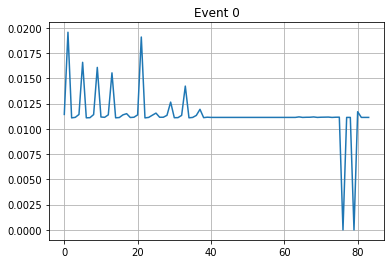

In [7]:
plt.grid()
plt.plot(np.arange(N), train_data[500])
plt.title("Event 0")
plt.show()

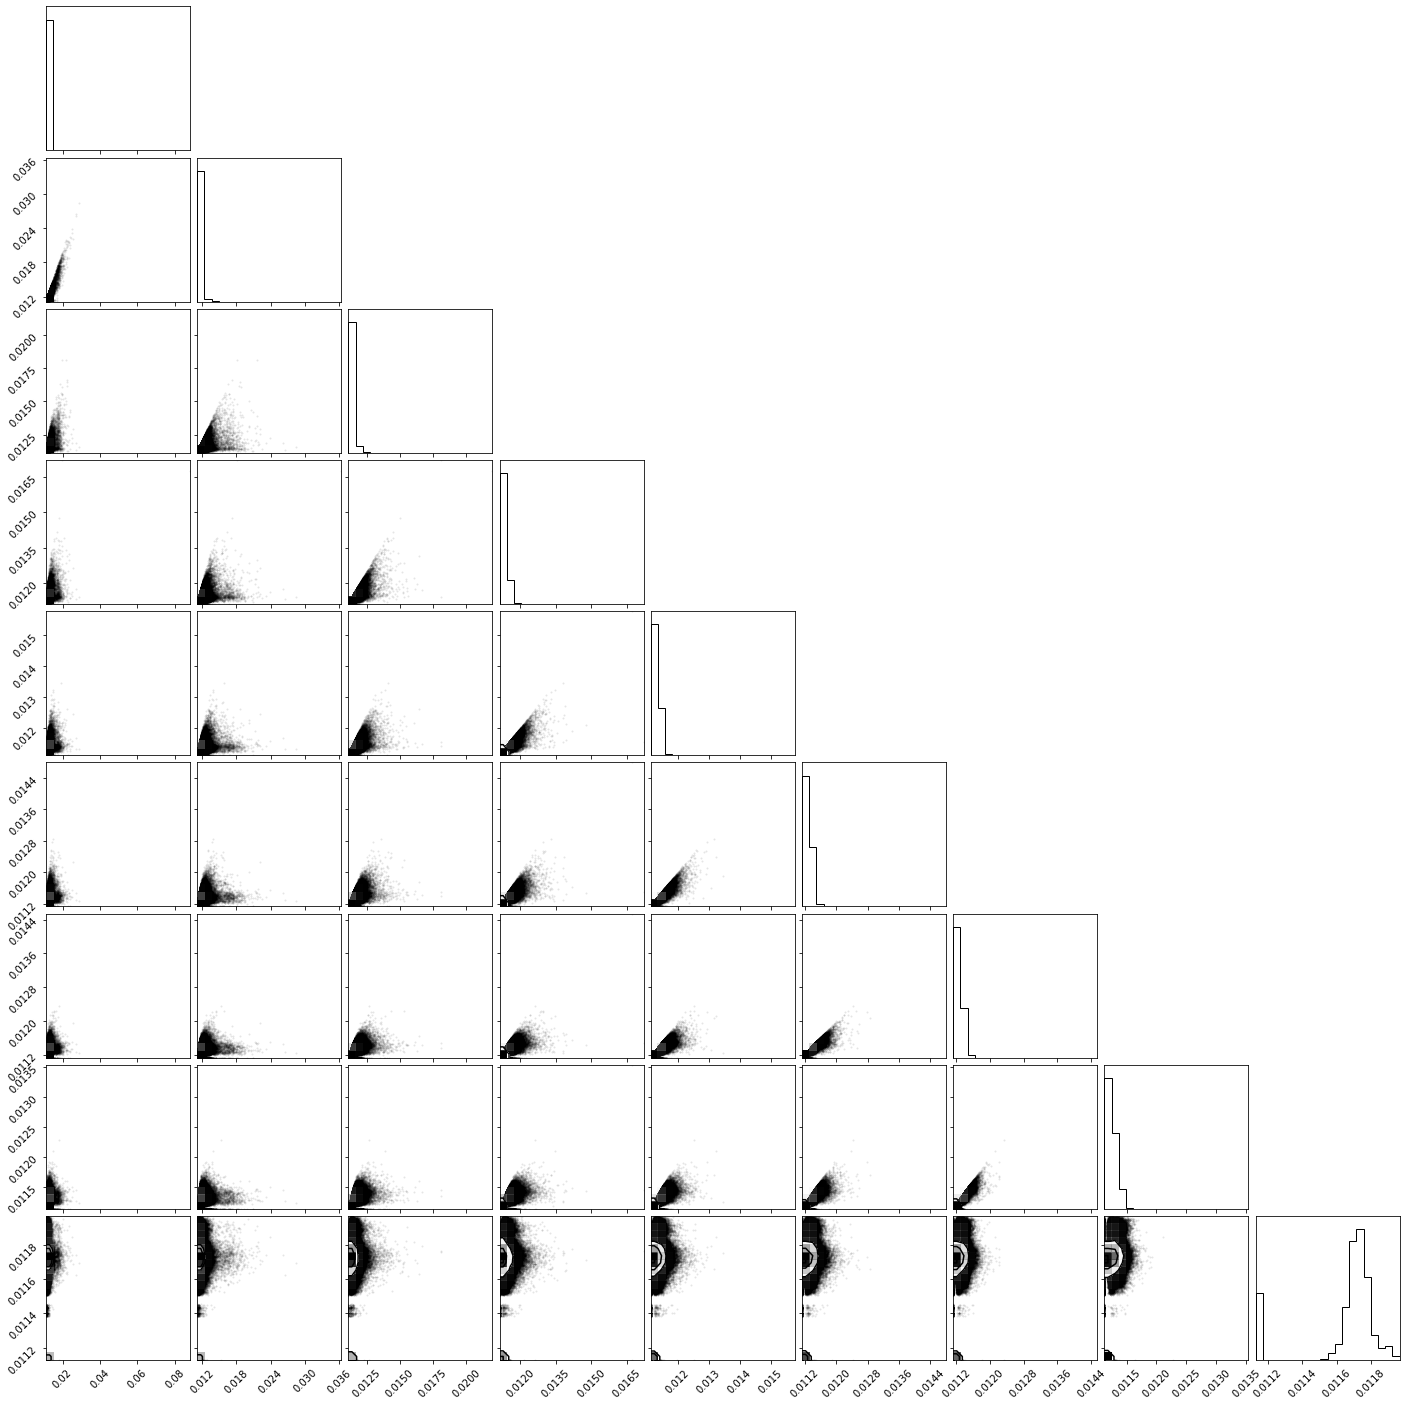

In [8]:
selected_column_ranges = [(0,0),(4,4),(8,8),(12,12),(16,16),(20,20),(24,24),(28,28),(80,80)] #jet pts and PU vars only for corener plot
selected_columns = np.concatenate([train_data[:, start:end+1] for start, end in selected_column_ranges], axis=1)

figure = corner.corner(selected_columns)

In [9]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(N, activation="tanh"),
      layers.Dense(N/2, activation="tanh"),
      #layers.Dense(20, activation="relu")
      #layers.Dense(16, activation="relu")
      layers.Dense(N//4, activation="tanh")
       ])

    self.decoder = tf.keras.Sequential([
      #layers.Dense(20, activation="relu"),
      #layers.Dense(40, activation="relu"),
      layers.Dense(N/2, activation="tanh"),
      layers.Dense(N, activation="tanh")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [10]:
opt = keras.optimizers.Adam(learning_rate=0.005)
autoencoder.compile(optimizer=opt, loss='mae')

In [11]:
history = autoencoder.fit(train_data, train_data, 
          epochs=30, 
          batch_size=128,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/30
6369/6369 [==============================] - 11s 2ms/step - loss: 6.7237e-04 - val_loss: 5.6094e-04
Epoch 2/30
6369/6369 [==============================] - 9s 1ms/step - loss: 5.9794e-04 - val_loss: 5.5047e-04
Epoch 3/30
6369/6369 [==============================] - 9s 1ms/step - loss: 5.8292e-04 - val_loss: 5.6159e-04
Epoch 4/30
6369/6369 [==============================] - 9s 1ms/step - loss: 5.7745e-04 - val_loss: 5.6711e-04
Epoch 5/30
6369/6369 [==============================] - 9s 1ms/step - loss: 5.6778e-04 - val_loss: 5.4658e-04
Epoch 6/30
6369/6369 [==============================] - 9s 1ms/step - loss: 5.6575e-04 - val_loss: 6.2546e-04
Epoch 7/30
6369/6369 [==============================] - 9s 1ms/step - loss: 5.6862e-04 - val_loss: 6.1471e-04
Epoch 8/30
6369/6369 [==============================] - 9s 1ms/step - loss: 5.6076e-04 - val_loss: 5.1629e-04
Epoch 9/30
6369/6369 [==============================] - 9s 1ms/step - loss: 5.9313e-04 - val_loss: 5.3241e-04
Epoch 10/

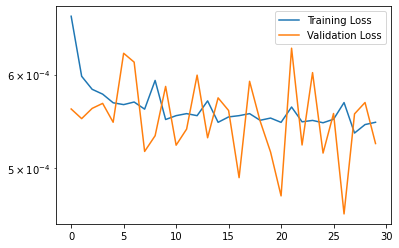

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.yscale("log")
plt.legend()

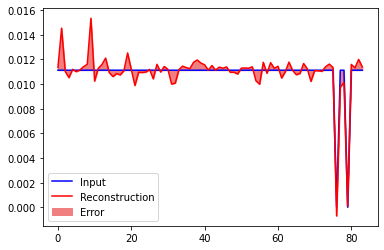

In [13]:
encoded_data = autoencoder.encoder(test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

randIndx = 5

plt.plot(test_data[randIndx], 'b')
#plt.plot(encoded_data[randIndx], 'r')
plt.plot(decoded_data[randIndx], 'r')
#plt.fill_between(np.arange(N), encoded_data[randIndx], test_data[randIndx], color='lightcoral')
plt.fill_between(np.arange(N), decoded_data[randIndx], test_data[randIndx], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

25476/25476 [==============================] - 18s 688us/step


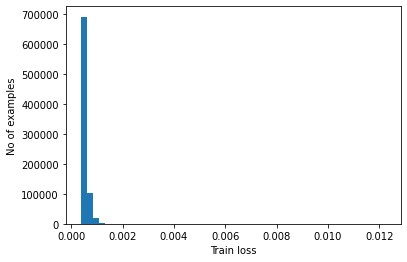

In [14]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

6369/6369 [==============================] - 4s 690us/step


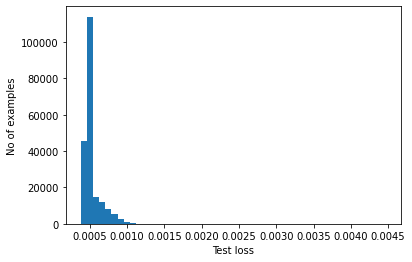

In [15]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)

plt.hist(test_loss[None,:], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [16]:
min_ind = tf.argmin(test_loss)
max_ind = tf.argmax(test_loss)

#print(test_data[min_ind])

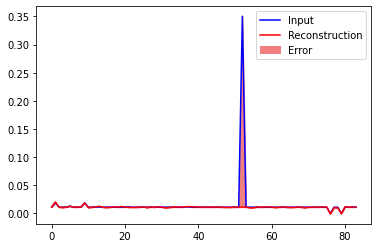

In [17]:
ind = max_ind

plt.plot(test_data[ind], 'b')
plt.plot(decoded_data[ind], 'r')
ratio = (test_data[ind] / decoded_data[ind])
#plt.plot(ratio, 'r')

plt.fill_between(np.arange(N), decoded_data[ind], test_data[ind], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
#plt.yscale("log")
plt.show()

In [18]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Mean: ", np.mean(train_loss))
print("Threshold: ", threshold)

Mean:  0.0005244327
Threshold:  0.0006378981


In [19]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [20]:
preds = predict(autoencoder, test_data, threshold)
print(preds)
print_stats(preds, test_labels)

tf.Tensor([ True  True  True ...  True  True  True], shape=(203805,), dtype=bool)


NameError: name 'test_labels' is not defined